## Notebook for imaging eMERLIN calibrated data

This illustrates how RASCIL may be used to image eMERLIN data. The example data is from:

http://www.e-merlin.ac.uk/distribute/support/tutorials/3C277.1_20150505.tar

For a summary of the images produced by the eMERLIN CASA pipeline see:

 http://www.e-merlin.ac.uk/distribute/support/tutorials/3C277.1_20150505/weblog/index.html
 
 To run this notebook, you will need:
 
 - RASCIL from https://github.com/SKA-ScienceDataProcessor/rascil
 - The data from above
 - nifty-gridder from https://gitlab.mpcdf.mpg.de/ift/nifty_gridder
 

In [1]:
%matplotlib inline

import logging
import matplotlib.pyplot as plt
import os
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['image.cmap'] = 'rainbow'

import numpy


from rascil.processing_components import show_image, qa_image, export_image_to_fits, qa_gaintable, \
    create_blockvisibility_from_ms, list_ms, integrate_visibility_by_channel, \
    concatenate_blockvisibility_frequency,   convert_blockvisibility_to_stokesI, \
    convert_blockvisibility_to_visibility, convert_visibility_to_blockvisibility, weight_visibility,\
    create_image_from_visibility, advise_wide_field, create_calibration_controls, gaintable_plot, \
    deconvolve_cube, restore_cube



from rascil.processing_components.imaging.ng import invert_ng


cwd = os.getcwd()

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.FileHandler('%s/eMERLIN_imaging.log' % cwd))

logging.basicConfig(filename='%s/eMERLIN_imaging.log' % cwd,
                    filemode='w',
                    format='%(date)s %(asctime)s.%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.DEBUG)
log.info("Logging to %s/eMERLIN_imaging.log" % cwd)



#### List the contents of the MeasurementSet: sources and data descriptors

In [2]:
print(list_ms('../../data/3C277.1_avg.ms'))

(['1302+5748', '0319+415', '1407+284', '1252+5634', '1331+305'], [0, 1, 2, 3])


#### Load just 3C277.1 (1252+5634) and '1302+5748'

In [7]:
selected_sources = ['1252+5634']
bvis_list = create_blockvisibility_from_ms('../../data/3C277.1_avg.ms', datacolumn='CORRECTED_DATA',
                                           selected_sources=selected_sources)
sources = numpy.unique([bv.source for bv in bvis_list])
print(sources)

['1252+5634']
(4.348393440246582+1.3961673974990845j)


In [8]:
flag = False
if flag:
    
    import aoflagger as aof
    
    bvis=bvis_list[0]
    ntimes, nant, _, nch, npol = bvis.vis.shape

    aoflagger = aof.AOFlagger()
    # Shape of returned buffer is actually nch, ntimes
    data = aoflagger.make_image_set(ntimes, nch, npol*2)

    print("Number of times: " + str(data.width()))
    print("Number of antennas:" +str(nant))
    print("Number of channels: " + str(data.height()))
    print("Number of polarisations: " + str(npol))
    eMERLIN_strategy = aoflagger.load_strategy('eMERLIN_strategy.rfis')

    for a2 in range(0, nant-1):
        for a1 in range(a2+1,nant):
            for pol in range(npol):
                data.set_image_buffer(2*pol,   numpy.real(bvis.vis[:,a1,a2,:,pol]).T)
                data.set_image_buffer(2*pol+1, numpy.imag(bvis.vis[:,a1,a2,:,pol]).T)


            flags = aoflagger.run(eMERLIN_strategy, data)
            flagvalues = flags.get_buffer() * 1
            bvis.data['flags'][:,a1,a2,:,:] = flagvalues.T[...,numpy.newaxis]
            flagcount = sum(sum(flagvalues))
            print(str(a1) + " " + str(a2) + ": percentage flags on zero data: " 
                  + str(flagcount * 100.0 / (nch*ntimes)) + "%")

#### Average across all each BlockVisibility over all 128 channels, and then concatenate into single BlockVisibilitys, one per source

In [9]:
avis_list = [integrate_visibility_by_channel(bvis) for bvis in bvis_list]
print(numpy.max(avis_list[0].flagged_vis))
blockvis = [concatenate_blockvisibility_frequency(avis_list[isource * 4:(isource * 4 + 4)])
            for isource, source in enumerate(sources)]
print(numpy.max(blockvis[0].flagged_vis))

(0.5942149855506919+0.25849645483049244j)
(0.5942149855506919+0.25849645483049244j)


#### Run one of:
 - Invert + deconvolve + restore (mode='invert')
 - Continuum Imaging Pipeline (mode='cip')
 - ICAL pipeline (mode='ical')

39888.92642211914
39888.92642211914
39888.92642211914
39888.92642211914


Processing 1252+5634 via invert pipeline


(0.5628157878449809+0.24727594336057643j)
[[4.05665186e-09]]
Quality assessment:
	Origin: qa_image
	Context: Deconvolved image
	Data:
		shape: '(1, 1, 1024, 1024)'
		max: '0.0036272867214082053'
		min: '-0.0009807507175889553'
		maxabs: '0.0036272867214082053'
		rms: '1.4188489569253859e-05'
		sum: '-0.030812973739534736'
		medianabs: '0.0'
		medianabsdevmedian: '0.0'
		median: '0.0'

Quality assessment:
	Origin: qa_image
	Context: Residual image
	Data:
		shape: '(1, 1, 1024, 1024)'
		max: '0.055089626911652596'
		min: '-0.052399765522608534'
		maxabs: '0.055089626911652596'
		rms: '0.006744988605371439'
		sum: '45.905253126508846'
		medianabs: '0.0018630935065471269'
		medianabsdevmedian: '0.0018633364257326604'
		median: '1.207813094811434e-05'

Quality assessment:
	Origin: qa_image
	Context: Restored image
	Data:
		shape: '(1, 1, 1024, 1024)'
		max: '0.071010161721582

<Figure size 864x864 with 0 Axes>

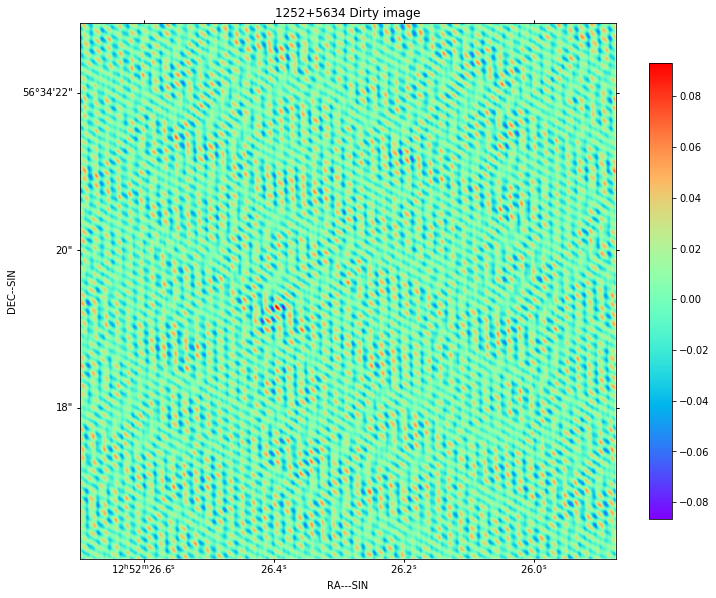

<Figure size 864x864 with 0 Axes>

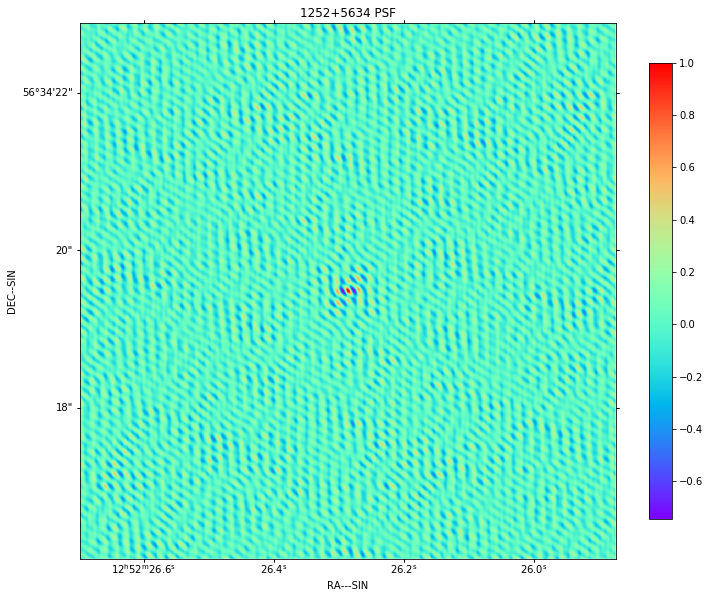

<Figure size 864x864 with 0 Axes>

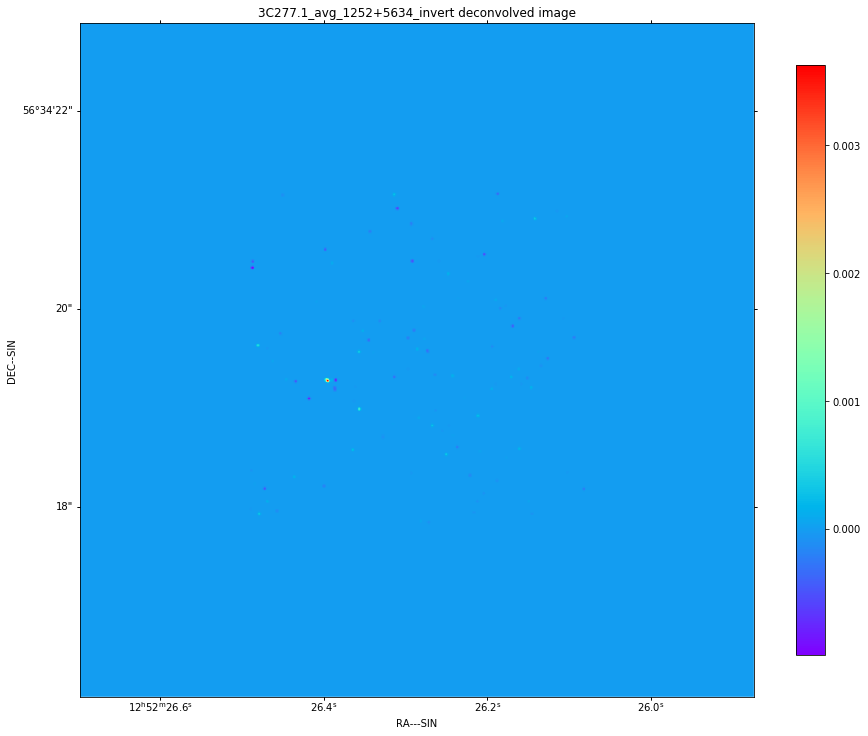

<Figure size 864x864 with 0 Axes>

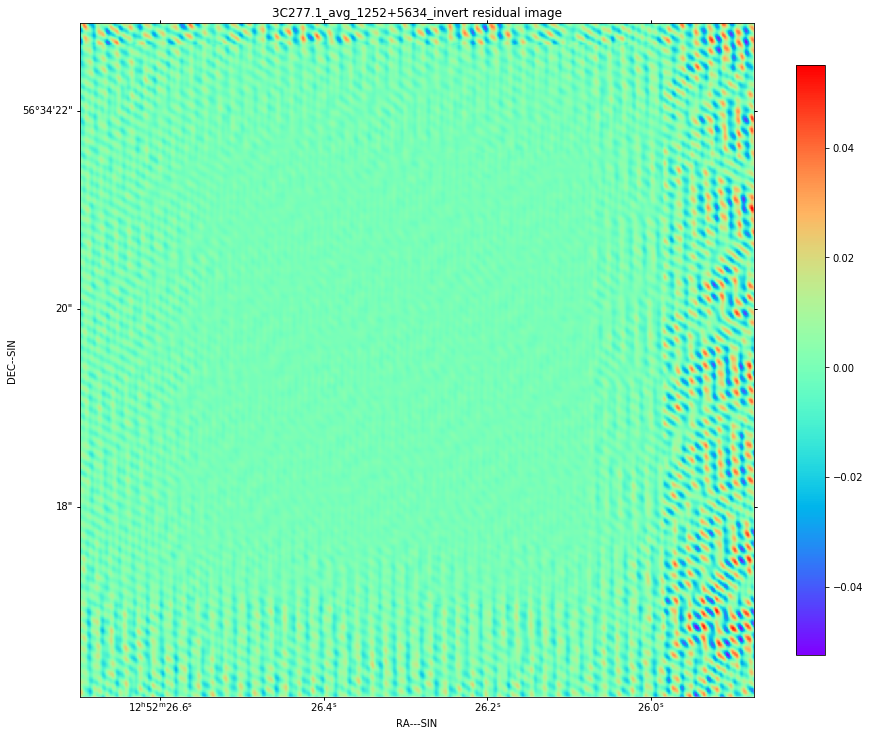

<Figure size 864x864 with 0 Axes>

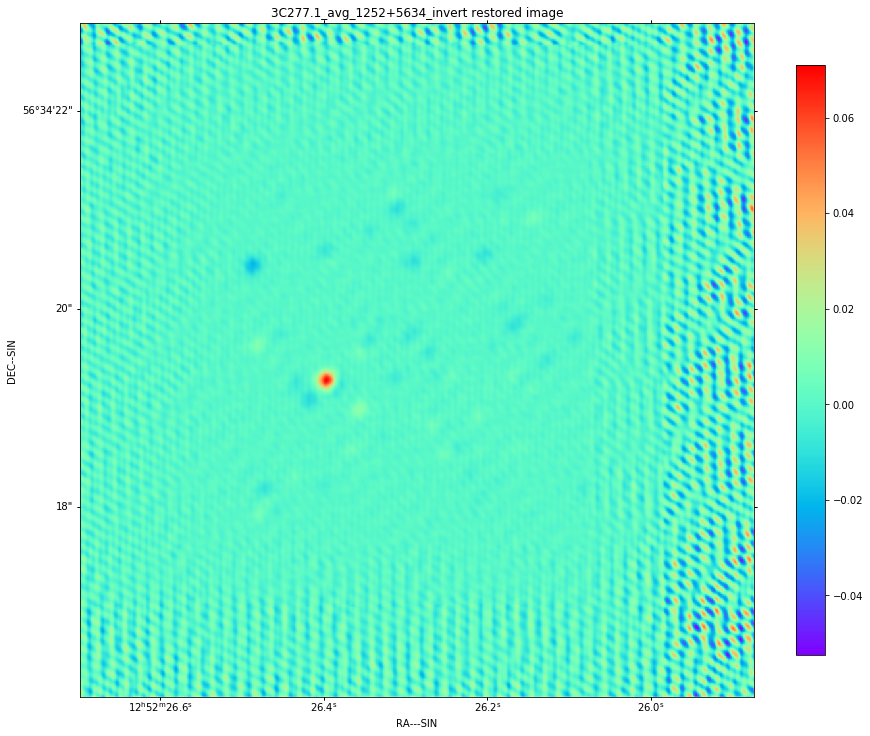

<Figure size 864x864 with 0 Axes>

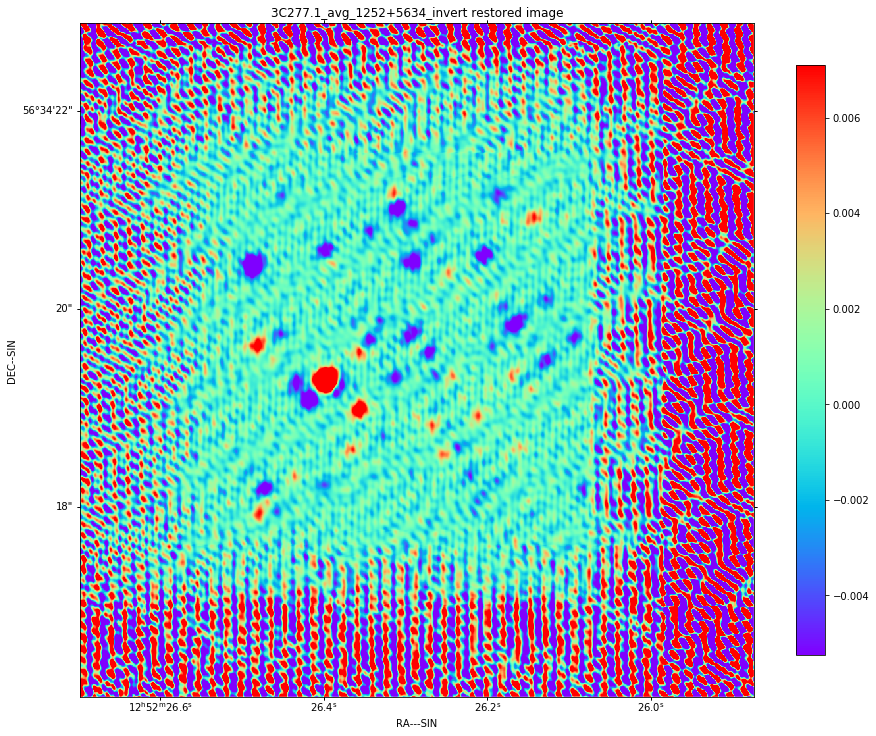

In [10]:
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['image.cmap'] = 'rainbow'

from rascil.workflows import continuum_imaging_list_serial_workflow, \
    ical_list_serial_workflow

advice = advise_wide_field(avis_list[0], verbose=False)
for svis in blockvis:
    frequency = [numpy.mean(svis.frequency)]
    channel_bandwidth = [numpy.sum(svis.channel_bandwidth)]
    ivis = convert_blockvisibility_to_stokesI(svis)
    print(numpy.max(ivis.flagged_weight))
    model = create_image_from_visibility(ivis, npixel=1024, 
                                         cellsize=advice['cellsize']/3.0, nchan=1,
                                         frequency=frequency, 
                                         channel_bandwidth=channel_bandwidth)
    cvis = convert_blockvisibility_to_visibility(ivis)
    print(numpy.max(cvis.flagged_weight))
    cvis = weight_visibility(cvis, model)
    print(numpy.max(cvis.flagged_weight))
    ivis = convert_visibility_to_blockvisibility(cvis)
    print(numpy.max(ivis.flagged_weight))
    
    for mode in ["invert"]:
        
        print("\n")
        print("Processing {source:s} via {mode:s} pipeline".format(source=svis.source, 
                                                                   mode=mode))
        print("\n")

        filename_root = "3C277.1_avg_{source:s}_{mode:s}".format(source=svis.source, mode=mode)

        if mode == "ical":
            controls = create_calibration_controls()
            controls['T']['first_selfcal'] = 1
            controls['T']['phase_only'] = True
            controls['T']['timeslice'] = 3.0
            controls['G']['first_selfcal'] = 10
            controls['G']['phase_only'] = False
            controls['G']['timeslice'] = 3600.0


            deconvolved, residual, restored, gt_list = \
                ical_list_serial_workflow([ivis], [model], context='ng', nmajor=15,
                                          niter=1000, algorithm='msclean',
                                          scales=[0, 3, 10], gain=0.1,
                                          fractional_threshold=0.5,
                                          threshold=0.0015,
                                          window_shape='quarter',
                                          do_wstacking=False,
                                          global_solution=False,
                                          calibration_context='TG',
                                          do_selfcal=True,
                                          controls=controls)
            deconvolved = deconvolved[0]
            residual = residual[0][0]
            restored = restored[0]
            gt = gt_list[0]['T']
            print(qa_gaintable(gt))
            fig, ax = plt.subplots(1,1)
            gaintable_plot(gt, ax, value='phase')
            plt.show(block=False)

            gt = gt_list[0]['G']
            print(qa_gaintable(gt))
            fig, ax = plt.subplots(1,1)
            gaintable_plot(gt, ax, value='amp')
            plt.show(block=False)


        elif mode == "cip":
            deconvolved, residual, restored = \
                continuum_imaging_list_serial_workflow([ivis], [model], context='ng',
                                                       nmajor=10, niter=1000, 
                                                       algorithm='msclean',
                                                       scales=[0, 3, 10], gain=0.1,
                                                       fractional_threshold=0.5,
                                                       threshold=0.0015,
                                                       window_shape='quarter',
                                                       do_wstacking=False)

            deconvolved = deconvolved[0]
            residual = residual[0][0]
            restored = restored[0]

        else:
            mode = "invert"
            print(numpy.max(ivis.flagged_vis))
            dirty, sumwt = invert_ng(ivis, model, do_wstacking=False)
            print(sumwt)
            plt.clf()
            show_image(dirty, title=svis.source + " Dirty image", cm="rainbow")
            plt.show(block=False)

            psf, sumwt = invert_ng(ivis, model, do_wstacking=False, dopsf=True)
            plt.clf()
            show_image(psf, title=svis.source + " PSF", cm="rainbow")
            plt.show(block=False)

            deconvolved, residual = deconvolve_cube(dirty, psf, niter=1000, algorithm='msclean',
                                                    fractional_threshold=1e-3,
                                                    scales=[0, 3, 10], gain=0.1, 
                                                    threshold=0.003,
                                                    window_shape='quarter')
            restored = restore_cube(deconvolved, psf, residual)

        print(qa_image(deconvolved, context='Deconvolved image'))
        plt.clf()
        show_image(deconvolved, title=filename_root + " deconvolved image", cm="rainbow")
        plt.tight_layout()
        plt.show(block=False)
        filename = "{root:s}_deconvolved.fits".format(root=filename_root)
        export_image_to_fits(deconvolved, filename)


        print(qa_image(residual, context='Residual image'))
        plt.clf()
        show_image(residual, title=filename_root + " residual image", cm="rainbow")
        plt.tight_layout()
        plt.show(block=False)
        filename = "{root:s}_residual.fits".format(root=filename_root)
        export_image_to_fits(residual, filename)


        print(qa_image(restored, context='Restored image'))
        plt.clf()
        show_image(restored, title=filename_root + " restored image", cm="rainbow")
        plt.tight_layout()
        plt.show(block=False)        

        plt.clf()
        show_image(restored, title=filename_root + " restored image", vscale=0.1, cm="rainbow")
        plt.tight_layout()
        plt.show(block=False)        

        filename = "{root:s}_restored.fits".format(root=filename_root)
        export_image_to_fits(restored, filename)
    